# 目的

学習した機械学習器の学習・予測データの予測に寄与した特徴量を可視化する

## 機械学習モデルの解釈
SHAPによって、入出力値から、出力に寄与した特徴量をSHAP値で表現できる。  
しかし、前処理でPCAを実施しているため、SHAPで出力される特徴量はPCAのままである。  
このままでは出力に寄与した遺伝子名（生の特徴量）がわからないため、PCAのloading（因子負荷量：主成分と元の特徴量を標準化した変数の相関係数）をSHAPの平均絶対値と内積をとってordinal score：順序スコアを定義する。


In [1]:
# 基本的なライブラリ
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)

# XAI
import shap

# config python file
import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# SHAP

In [2]:
def save_shap_instances(
    shap_explainer: callable,
    shap_values: callable,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    functions.make_dir(save_file_path)
    functions.dill_dump(shap_explainer, "{0}/shap_explainer.pkl".format(save_file_path))
    functions.dill_dump(shap_values, "{0}/shap_values.pkl".format(save_file_path))

In [3]:
def explain_model(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        max_evals="auto",
        seed=config.SEED,
    )
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

## 全体での実行

In [4]:
# 層別化する特徴量
def exec_shap(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set",
        "late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [5]:
# for p in range(80, 96):
pca_percentile = 80
# print("++++++++++" * 10)
# print(p)

# 実施したい学習の定義
model_order_dicts = [
    {
        "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
        "subgroup_column": "CLAUDIN_SUBTYPE",
        "subgroup": "claudin-low",
        "preprocess_name": "preprocess4numeric_pca{0}".format(pca_percentile),
    },
    {
        "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
        "subgroup_column": "CLAUDIN_SUBTYPE",
        "subgroup": "claudin-low",
        "preprocess_name": "preprocess4numeric_pca{0}".format(pca_percentile),
    },
    {
        "model_name": RandomSurvivalForest().__class__.__name__,
        "subgroup_column": "CLAUDIN_SUBTYPE",
        "subgroup": "claudin-low",
        "preprocess_name": "preprocess4numeric_pca{0}".format(pca_percentile),
    },
    {
        "model_name": ExtraSurvivalTrees().__class__.__name__,
        "subgroup_column": "CLAUDIN_SUBTYPE",
        "subgroup": "claudin-low",
        "preprocess_name": "preprocess4numeric_pca{0}".format(pca_percentile),
    },
]
"""
for model_order_dict in model_order_dicts:
    exec_shap(model_order_dict)
"""
pass

# ランキングの作成

## shap値の取得+pcaを利用した計算

In [6]:
def calc_score(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "/test_set",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    shap.plots.beeswarm(sv)
    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

## 予測で最も性能の高かったパターンでのスコア算出

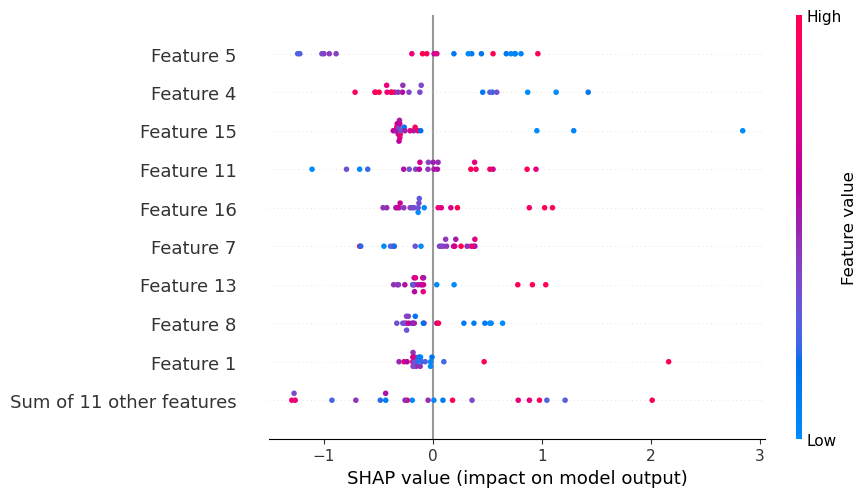

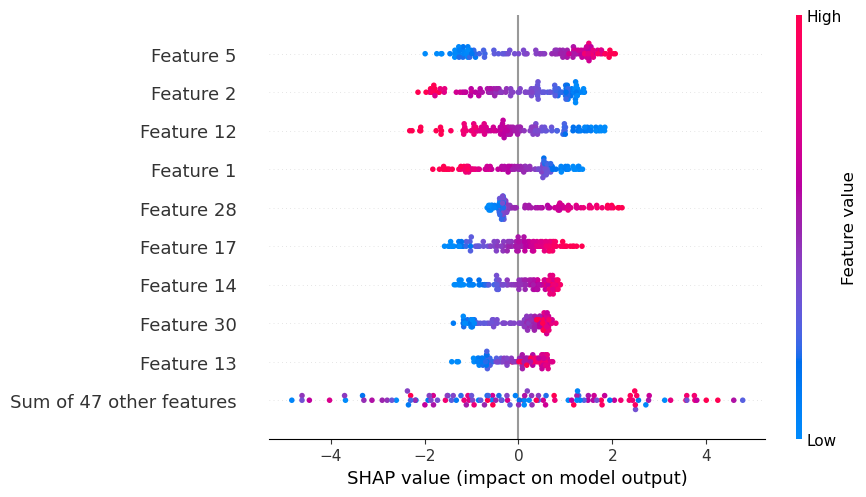

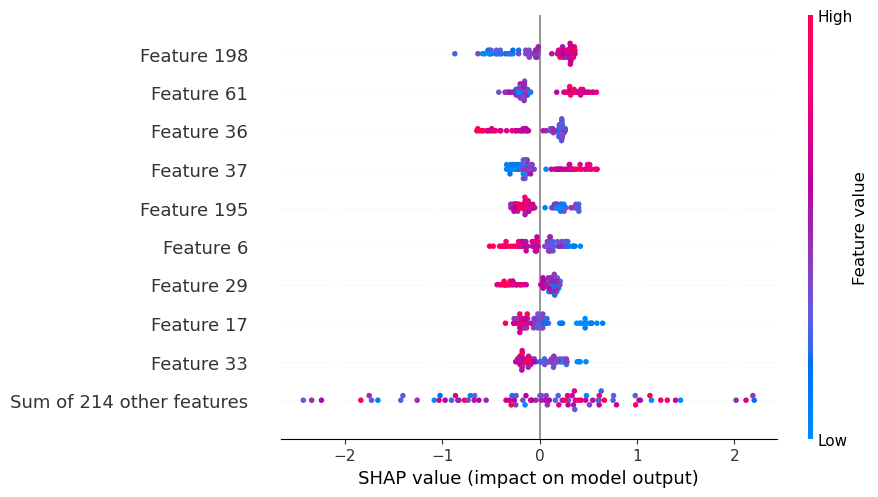

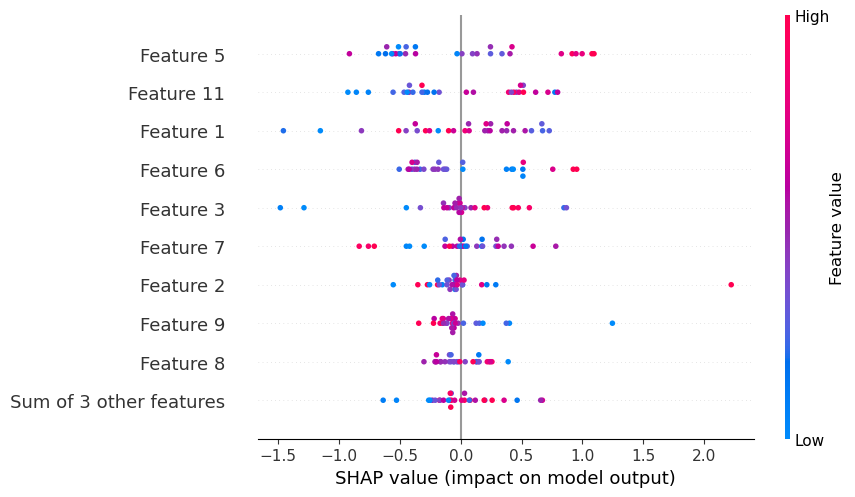

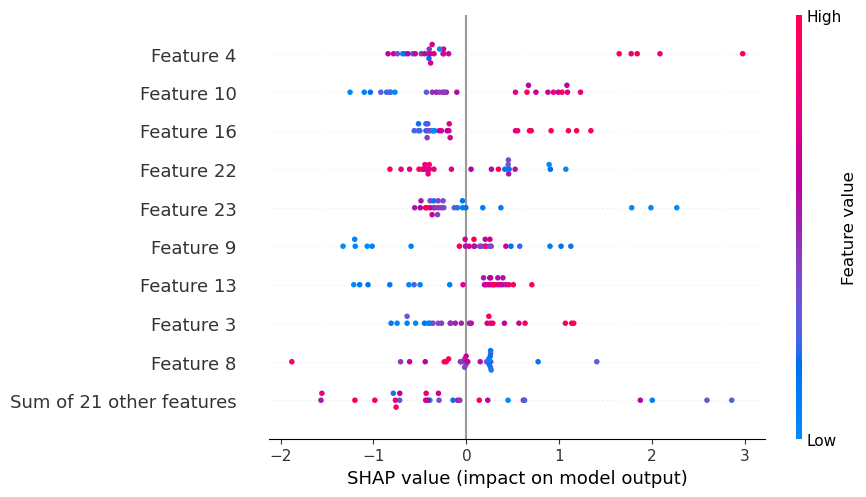

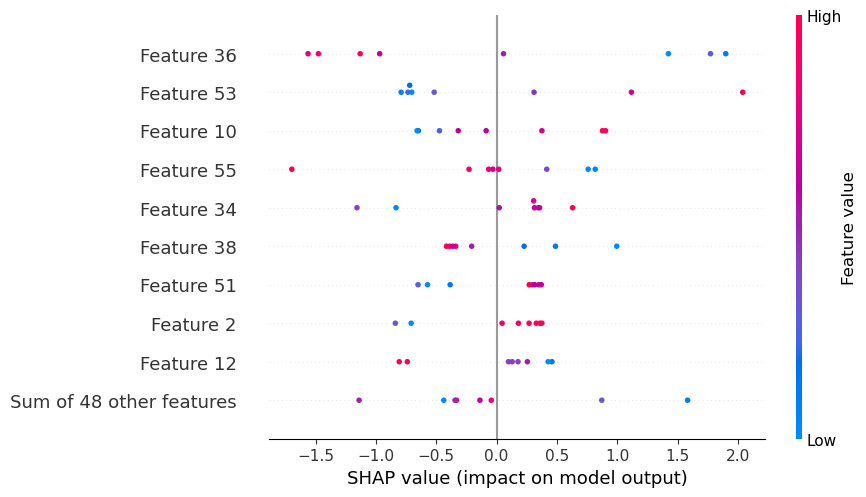

In [7]:
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow = calc_score(
    model_order_dict,
)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2 = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca51",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal = calc_score(model_order_dict)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal = calc_score(model_order_dict)

In [8]:
rank_claudinlow = rank_claudinlow.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA = rank_LumA.rename(columns={"gene name": "gene_LumA", "score": "score_LumA"})
rank_LumB = rank_LumB.rename(columns={"gene name": "gene_LumB", "score": "score_LumB"})
rank_Her2 = rank_Her2.rename(columns={"gene name": "gene_Her2", "score": "score_Her2"})
rank_Basal = rank_Basal.rename(columns={"gene name": "gene_Basal", "score": "Basal"})
rank_Normal = rank_Normal.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank = rank_claudinlow.copy()
df_rank = pd.merge(df_rank, rank_LumA, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_LumB, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Her2, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Normal, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Basal, right_index=True, left_index=True)
# 一時的な保存
df_rank.to_csv("./explain_score.csv")
df_rank

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,FHOD1,0.956681,KIF11,2.092441,HOXB7,0.532904,PRKCB,0.834020,FOXA1,1.397912,C20orf27,1.560924
1,PAK7,0.951701,ECT2,2.061204,ZFYVE19,0.528605,CLK1,0.833607,ZNF319,1.326685,TTYH3,1.461938
2,SON,0.946612,PTTG3,2.054869,TMEM132A,0.524554,IL23A,0.817898,SURF4,1.310726,URM1,1.447866
3,EIF4A1,0.924516,HMGB2,2.014932,ATOX1,0.524482,ARHGAP15,0.813478,CSNK2A2,1.286762,RNF126,1.441368
4,NRBF2,0.910935,HMMR,1.994203,TBCC,0.512003,ITK,0.808341,UCKL1,1.283544,NPNT,1.434121
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,GATA5,0.149008,AI015182,0.362954,CYP3A4,0.234109,SST,0.080691,AA723302,0.299589,AA740642,0.562294
24364,LOC100130673,0.147709,C13orf26,0.357638,RPL21,0.232001,AA586561,0.074428,AA860135,0.295605,COL21A1,0.559250
24365,AW299747,0.146727,LOC644662,0.355497,LHFPL1,0.230157,AW573137,0.073319,TP73,0.290191,AW444928,0.543618
24366,BQ028095,0.143598,LOC728724,0.345825,CCT7,0.229925,GAGE12B,0.072757,AK091007,0.283505,CYP2A6,0.543455


# 晩期再発者のみの調査

In [9]:
# 層別化する特徴量
def exec_shap4late_recurrences(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set",
        "late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}/{4}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
        "late_recurrences",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [10]:
# 晩期再発者向けに定義した順序スコアを計算するための関数
def calc_score4late_recurrences(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}/{4}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
        "late_recurrences",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap4late_recurrences(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

In [ ]:
# AROB
model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca92",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca94",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca82",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca95",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca88",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca83",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

In [11]:
# 修士論文
model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca51",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

In [12]:
rank_claudinlow_late = rank_claudinlow_late.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA_late = rank_LumA_late.rename(
    columns={"gene name": "gene_LumA", "score": "score_LumA"}
)
rank_LumB_late = rank_LumB_late.rename(
    columns={"gene name": "gene_LumB", "score": "score_LumB"}
)
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
rank_Basal_late = rank_Basal_late.rename(
    columns={"gene name": "gene_Basal", "score": "Basal"}
)
rank_Normal_late = rank_Normal_late.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank_late = rank_claudinlow_late.copy()
df_rank_late = pd.merge(df_rank_late, rank_LumA_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_LumB_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_Her2_late, right_index=True, left_index=True)
df_rank_late = pd.merge(
    df_rank_late, rank_Normal_late, right_index=True, left_index=True
)
df_rank_late = pd.merge(
    df_rank_late, rank_Basal_late, right_index=True, left_index=True
)
# 一時的な保存
df_rank_late.to_csv("./explain_score_late.csv")
df_rank_late

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,ASB1,1.374585,KIF11,5.699047,HOXB7,0.532904,PRKCB,0.834020,ZNF319,2.180555,TIGD5,0.434934
1,SQRDL,1.369625,HMMR,5.575468,ZFYVE19,0.528605,CLK1,0.833607,FOXA1,2.115717,CDC34,0.434641
2,FHOD1,1.364592,ECT2,5.496492,TMEM132A,0.524554,IL23A,0.817898,C1orf61,2.107689,GATAD2B,0.434093
3,CMTM7,1.341143,PTTG3,5.457813,ATOX1,0.524482,ARHGAP15,0.813478,MLPH,2.047868,TTYH3,0.431419
4,NRBF2,1.333215,RPN2,5.389564,TBCC,0.512003,ITK,0.808341,GFAP,2.046266,TOMM34,0.429102
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,OR6Q1,0.220612,AI015182,1.033629,CYP3A4,0.234109,SST,0.080691,AK091007,0.476710,AW444928,0.168156
24364,BQ028095,0.218398,OR51B4,1.025126,RPL21,0.232001,AA586561,0.074428,BE617126,0.465409,AK129671,0.167453
24365,CELP,0.217595,LOC728724,0.994297,LHFPL1,0.230157,AW573137,0.073319,BX248300,0.455254,STON1,0.162322
24366,AW299747,0.201725,LOC644662,0.961024,CCT7,0.229925,GAGE12B,0.072757,COX7B2,0.454242,BG205964,0.160039


In [15]:
df_rank

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,FHOD1,0.956681,KIF11,2.092441,HOXB7,0.532904,PRKCB,0.834020,FOXA1,1.397912,C20orf27,1.560924
1,PAK7,0.951701,ECT2,2.061204,ZFYVE19,0.528605,CLK1,0.833607,ZNF319,1.326685,TTYH3,1.461938
2,SON,0.946612,PTTG3,2.054869,TMEM132A,0.524554,IL23A,0.817898,SURF4,1.310726,URM1,1.447866
3,EIF4A1,0.924516,HMGB2,2.014932,ATOX1,0.524482,ARHGAP15,0.813478,CSNK2A2,1.286762,RNF126,1.441368
4,NRBF2,0.910935,HMMR,1.994203,TBCC,0.512003,ITK,0.808341,UCKL1,1.283544,NPNT,1.434121
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,GATA5,0.149008,AI015182,0.362954,CYP3A4,0.234109,SST,0.080691,AA723302,0.299589,AA740642,0.562294
24364,LOC100130673,0.147709,C13orf26,0.357638,RPL21,0.232001,AA586561,0.074428,AA860135,0.295605,COL21A1,0.559250
24365,AW299747,0.146727,LOC644662,0.355497,LHFPL1,0.230157,AW573137,0.073319,TP73,0.290191,AW444928,0.543618
24366,BQ028095,0.143598,LOC728724,0.345825,CCT7,0.229925,GAGE12B,0.072757,AK091007,0.283505,CYP2A6,0.543455


In [16]:
df_rank_late

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,ASB1,1.374585,KIF11,5.699047,HOXB7,0.532904,PRKCB,0.834020,ZNF319,2.180555,TIGD5,0.434934
1,SQRDL,1.369625,HMMR,5.575468,ZFYVE19,0.528605,CLK1,0.833607,FOXA1,2.115717,CDC34,0.434641
2,FHOD1,1.364592,ECT2,5.496492,TMEM132A,0.524554,IL23A,0.817898,C1orf61,2.107689,GATAD2B,0.434093
3,CMTM7,1.341143,PTTG3,5.457813,ATOX1,0.524482,ARHGAP15,0.813478,MLPH,2.047868,TTYH3,0.431419
4,NRBF2,1.333215,RPN2,5.389564,TBCC,0.512003,ITK,0.808341,GFAP,2.046266,TOMM34,0.429102
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,OR6Q1,0.220612,AI015182,1.033629,CYP3A4,0.234109,SST,0.080691,AK091007,0.476710,AW444928,0.168156
24364,BQ028095,0.218398,OR51B4,1.025126,RPL21,0.232001,AA586561,0.074428,BE617126,0.465409,AK129671,0.167453
24365,CELP,0.217595,LOC728724,0.994297,LHFPL1,0.230157,AW573137,0.073319,BX248300,0.455254,STON1,0.162322
24366,AW299747,0.201725,LOC644662,0.961024,CCT7,0.229925,GAGE12B,0.072757,COX7B2,0.454242,BG205964,0.160039
